In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy.random as npr
import multiprocessing
import os
import pandas as pd
import logging  # Setting up the loggings to monitor gensim
import stellargraph as sg
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)

ModuleNotFoundError: No module named 'stellargraph'

# Implementing the Node2Vec paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [12]:
class Node2Vec():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int,
                        p : float,
                        q : float
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.
                p : float
                        The return parameter.
                q : float
                        The in-out parameter.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)
                self.p = p
                self.q = q
                
                # Cutoffs for sampling
                self.p0 = 1 / self.p / max(1, self.p, self.q)
                self.p1 = 1/  max(1, self.p, self.q)
                self.p2 = 1 / self.q / max(1, self.p, self.q)
                
                # Make the adjacency list using the graph
                self.adj_list = []
                for i in range(len(self.g)):
                    neighbors = np.where(self.g[i] > 0)[0]  # Get neighbor indices
                    weights = self.g[i, neighbors]  # Get corresponding edge weights
    
                    # Sort neighbors and weights by weight
                    sorted_neighbors_weights = sorted(zip(neighbors, weights), key=lambda x: x[0])
                    sorted_neighbors, sorted_weights = zip(*sorted_neighbors_weights)

                    self.adj_list.append(list(zip(sorted_neighbors, sorted_weights / np.sum(sorted_weights))))
        
        def get_random_neighbour(self, vertex : 'int') -> 'int':
                """
                Fetches a random neighbour of a given vertex
                by sampling on the basis of the edge weights
                
                Parameters
                ----------
                vertex : int
                        The vertex whose neighbour we will sample
                        
                Returns
                -------
                int
                        The neighbour that was sampled
                """
                # Sample a neighbour with probability proportional
                # to the edge weight from vertex --> neighbour
                neighbours, weights = zip(*self.adj_list[vertex])
                
                # Sample a vertex with probability proportional 
                # to the weight of the edge joining it.
                return np.random.choice(neighbours, p=weights)
                    
        def second_order_biased_random_walk(
                        self,
                        adj_mat : 'list[list[int]]', 
                        walk_len : 'int', 
                        start_node : 'int', 
                        return_parameter :'float', 
                        in_out_parameter : 'float'
                        ) -> np.array:
                """
                Return a walk based on a 2nd order Markov Chain like transition.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.
                return_parameter : float
                        The value of the "p" parameter
                in_out_parameter : float
                        The value of the "q" parameter
                
                Returns
                -------
                np.array
                        List of nodes in the random walk.  
                
                """
                # Array to store the walk
                walk = [
                        start_node,
                        self.get_random_neighbour(start_node) # The prev_node is never Null
                ]

                # Generate the rest of the walk
                for i in range(2, walk_len):
                    # Variable to check whether we added to walk
                    found = False
                    
                    # Kep running until sampled in the red region
                    while not found:
                        new_node = self.get_random_neighbour(walk[-1])
                        r = np.random.rand()
                        
                        # Check if we will go back to the same node
                        if new_node == walk[-2]:
                            if r < self.p0:
                                found = True
                        
                        # Check if we are going to move by a distance of 1
                        elif self.g[walk[-2]][new_node]:
                            if r < self.p1:
                                found = True
                                    
                        else: # So we are moving by a distance of 2
                            if r < self.p2:
                                found = True
                                
                    walk.append(new_node)
            
                return walk

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []
                

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t starting from this "vertex"
                        for _ in range(self.gamma):
                                walks.append(self.second_order_biased_random_walk(self.g, self.t, vertex, self.p, self.q))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """          
                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        negative= 10,
                        sg=1,
                        alpha=0.05,
                        epochs=self.epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        

In [13]:
def plot_graph (G , node_colours):
    plt.figure(figsize=(8,8))
    # scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]
    nx.draw_networkx(G, with_labels=False, node_color= node_colours, node_size= node_sizes, edgecolors="black", alpha=0.9)
    plt.axis("off")
    plt.show()

## Showing DeepWalk

In [14]:
data_dir = os.path.expanduser(".")

edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

# Create the graph and add 'weight' attribute
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label", create_using=nx.Graph())
for edge in Gnx.edges(data=True):
        edge[2]['weight'] = 1.0  # Set a default weight if it's not specified in your edgelist

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
node_data = node_data.reset_index()

# Set node attributes
nx.set_node_attributes(Gnx, dict(zip(node_data["index"], node_data["subject"])), "paper")

In [ ]:
import os
import pandas as pd
import networkx as nx
from scipy.io import savemat

data_dir = os.path.expanduser(".")

# Read edge list
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

# Create the graph and add 'weight' attribute
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label", create_using=nx.Graph())
for edge in Gnx.edges(data=True):
    edge[2]['weight'] = 1.0  # Set a default weight if it's not specified in your edgelist

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)
node_data = node_data.reset_index()

# Set node attributes
nx.set_node_attributes(Gnx, dict(zip(node_data["index"], node_data["subject"])), "paper")

# Save the graph structure to a .mat file
savemat(os.path.join(data_dir, "cora_graph.mat"), {"network": nx.to_scipy_sparse_array(Gnx, nodelist=list(Gnx.nodes))})

# Save node attributes to a separate .mat file
node_attributes = dict(Gnx.nodes(data=True))
savemat(os.path.join(data_dir, "cora_node_attributes.mat"), {"node_attributes": node_attributes})


In [25]:
Gnx.nodes(data=True)

NodeDataView({1033: {'paper': 'Genetic_Algorithms'}, 35: {'paper': 'Genetic_Algorithms'}, 103482: {'paper': 'Neural_Networks'}, 103515: {'paper': 'Genetic_Algorithms'}, 1050679: {'paper': 'Genetic_Algorithms'}, 1103960: {'paper': 'Genetic_Algorithms'}, 1103985: {'paper': 'Genetic_Algorithms'}, 1109199: {'paper': 'Genetic_Algorithms'}, 1112911: {'paper': 'Genetic_Algorithms'}, 1113438: {'paper': 'Genetic_Algorithms'}, 1113831: {'paper': 'Genetic_Algorithms'}, 1114331: {'paper': 'Genetic_Algorithms'}, 1117476: {'paper': 'Genetic_Algorithms'}, 1119505: {'paper': 'Genetic_Algorithms'}, 1119708: {'paper': 'Genetic_Algorithms'}, 1120431: {'paper': 'Neural_Networks'}, 1123756: {'paper': 'Genetic_Algorithms'}, 1125386: {'paper': 'Theory'}, 1127430: {'paper': 'Genetic_Algorithms'}, 1127913: {'paper': 'Genetic_Algorithms'}, 1128204: {'paper': 'Genetic_Algorithms'}, 1128227: {'paper': 'Genetic_Algorithms'}, 1128314: {'paper': 'Genetic_Algorithms'}, 1128453: {'paper': 'Genetic_Algorithms'}, 112894

In [ ]:
nodenum = 1120431

In [ ]:
node_data[node_data["index"] == nodenum]

,index,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
174,1120431,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neural_Networks


In [ ]:
Gnx.nodes[1120431]

{'paper': 'Neural_Networks'}

In [ ]:
node_data

,index,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


In [ ]:
print("Number of nodes: {}".format(len(Gnx.nodes())))
print("Number of edges: {}".format(len(Gnx.edges())))
print("Average degree: {}".format(np.mean([val for (node, val) in Gnx.degree()])))
print("Is the graph connected? {}".format(nx.is_connected(Gnx)))


Number of nodes: 2708
Number of edges: 5278
Average degree: 3.8980797636632203
Is the graph connected? False


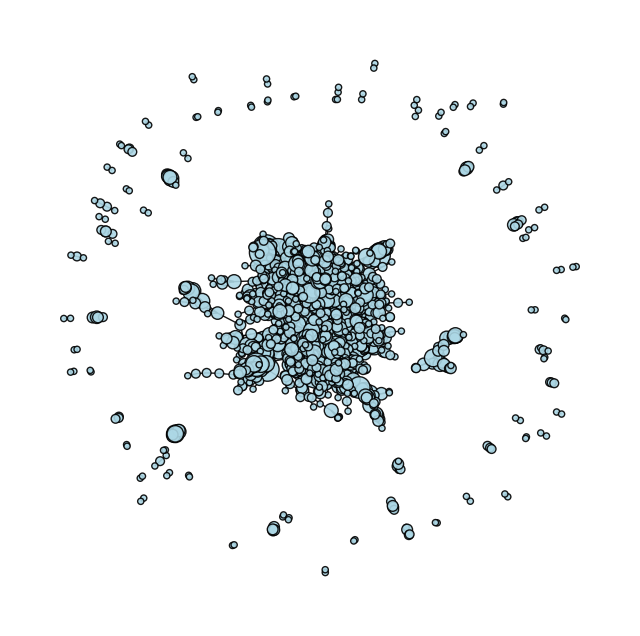

In [ ]:
# G = nx.les_miserables_graph()
G = Gnx
# draw a graph with light blue nodes outlined with black and grey edges (without labels)
plot_graph(G, "lightblue")

adjmat = nx.adjacency_matrix(G).todense()

In [ ]:
# adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
n2v = Node2Vec(adjmat, 10, 128, 10, 80, 1, 1)

In [ ]:
n2v.train(20, 0.05)

INFO - 2023-11-27 17:33:36,494: collecting all words and their counts
INFO - 2023-11-27 17:33:36,496: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-27 17:33:36,575: PROGRESS: at sentence #10000, processed 800000 words, keeping 2518 word types
INFO - 2023-11-27 17:33:36,653: PROGRESS: at sentence #20000, processed 1600000 words, keeping 2566 word types
INFO - 2023-11-27 17:33:36,708: collected 2708 word types from a corpus of 2166400 raw words and 27080 sentences
INFO - 2023-11-27 17:33:36,709: Creating a fresh vocabulary
INFO - 2023-11-27 17:33:36,718: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 2708 unique words (100.00% of original 2708, drops 0)', 'datetime': '2023-11-27T17:33:36.718269', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-27 17:33:36,719: Word2Vec lifecycle eve

In [ ]:
# Getting the embeddings from the model
embeddings = np.array(n2v.get_embeddings())
embeddings.shape

(2708, 128)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['Neural_Networks' 'Rule_Learning' 'Reinforcement_Learning' ...
 'Genetic_Algorithms' 'Case_Based' 'Neural_Networks']

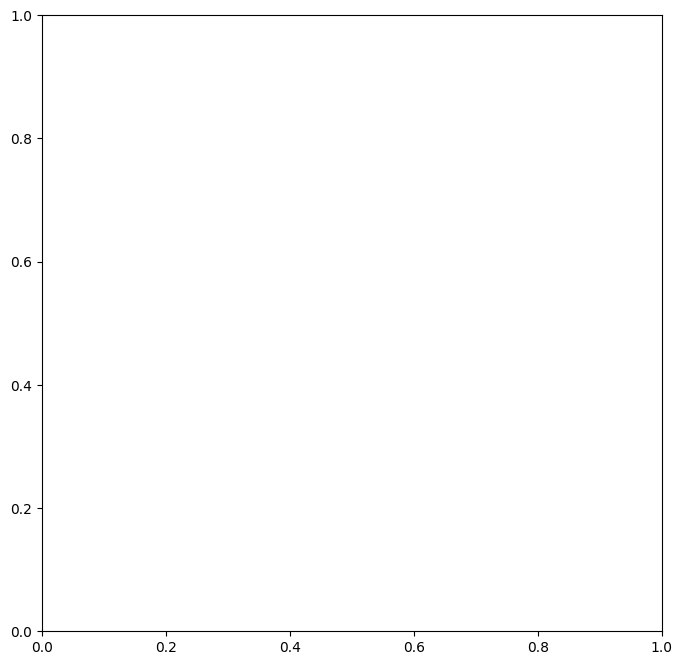

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(G, node_colors):
    plt.figure(figsize=(8, 8))

    # Scale node size by degree
    node_sizes = [v * 20 for v in dict(G.degree()).values()]

    nx.draw_networkx(G, with_labels=False, node_color=node_colors, cmap=plt.cm.Blues,
                     node_size=node_sizes, edgecolors="black", alpha=0.9)

    plt.axis("off")
    plt.show()

# Extract node colors from the "subject" column
node_colors = node_data["subject"].values

# Draw the graph with the specified node colors
plot_graph(Gnx, node_colors)

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


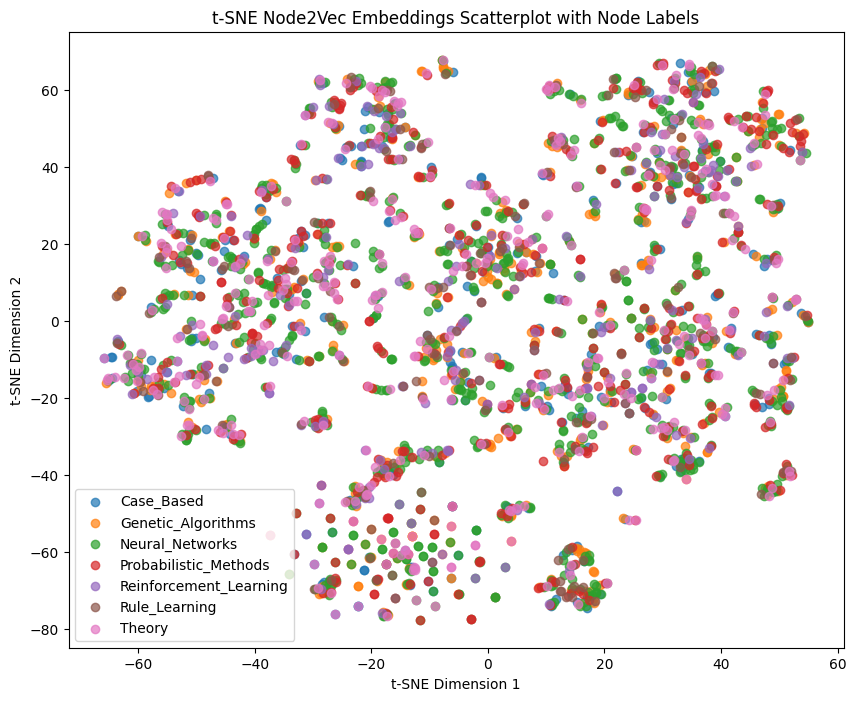

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'embeddings' is the numpy array with dimensions 2708x128
# Assuming 'node_data' is the DataFrame with node information, including labels

# Perform t-SNE to reduce the dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(embeddings)

# Extract node labels
node_labels = node_data["subject"].values

# Create a scatterplot
plt.figure(figsize=(10, 8))

# Loop through unique labels and plot them separately with a label in the legend
for label in np.unique(node_labels):
    indices = np.where(node_labels == label)
    plt.scatter(node_embeddings_2d[indices, 0], node_embeddings_2d[indices, 1], label=label, alpha=0.7)

# Add labels and legend
plt.title('t-SNE Node2Vec Embeddings Scatterplot with Node Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Show the plot
plt.show()


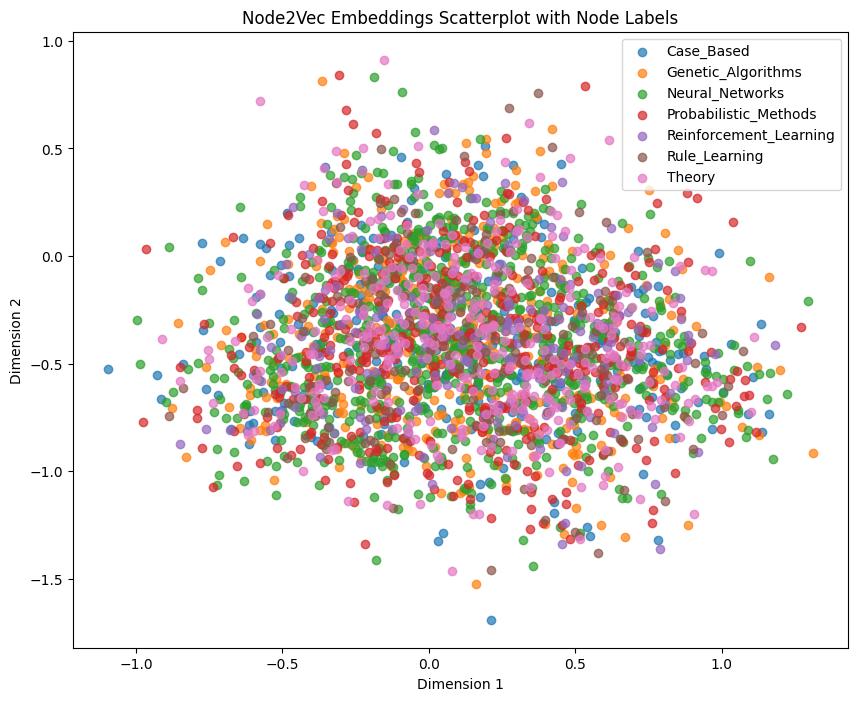

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'embeddings' is the numpy array with dimensions 2708x128
# Assuming 'node_data' is the DataFrame with node information, including labels

# Extract node labels and corresponding embeddings
node_labels = node_data["subject"].values
node_embeddings = embeddings

# Create a scatterplot
plt.figure(figsize=(10, 8))

# Loop through unique labels and plot them separately with a label in the legend
for label in np.unique(node_labels):
    indices = np.where(node_labels == label)
    plt.scatter(node_embeddings[indices, 0], node_embeddings[indices, 1], label=label, alpha=0.7)

# Add labels and legend
plt.title('Node2Vec Embeddings Scatterplot with Node Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

# Show the plot
plt.show()


## Showing Homophily

In [ ]:
print(Gnx.nodes[0])

KeyError: 0

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import networkx as nx

# Assuming embeddings is a 2D NumPy array with shape (2708, 2)
# Adjust the actual dimensions based on your embeddings
embeddings = np.array(n2v.get_embeddings())



# # Dimensionality reduction to 2 dimensions using t-SNE for visualization
# embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)

# # Create a DataFrame for easy plotting
# df = pd.DataFrame(embeddings_2d, columns=['Dimension 1', 'Dimension 2'])
# df['Label'] = label_numbers

# # Plot the scatter plot
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter('Dimension 1', 'Dimension 2', c='Label', data=df, cmap='viridis', edgecolors='w', s=50, alpha=0.8)

# # Add a legend
# legend_labels = [f"{label}: {i}" for label, i in label_mapping.items()]
# plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Node Labels", loc="upper right")

# # Set plot title and axis labels
# plt.title("2D Embedding Visualization")
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")

# # Display the plot
# plt.show()

[(1033, 'paper'), (35, 'paper'), (103482, 'paper'), (103515, 'paper'), (1050679, 'paper'), (1103960, 'paper'), (1103985, 'paper'), (1109199, 'paper'), (1112911, 'paper'), (1113438, 'paper'), (1113831, 'paper'), (1114331, 'paper'), (1117476, 'paper'), (1119505, 'paper'), (1119708, 'paper'), (1120431, 'paper'), (1123756, 'paper'), (1125386, 'paper'), (1127430, 'paper'), (1127913, 'paper'), (1128204, 'paper'), (1128227, 'paper'), (1128314, 'paper'), (1128453, 'paper'), (1128945, 'paper'), (1128959, 'paper'), (1128985, 'paper'), (1129018, 'paper'), (1129027, 'paper'), (1129573, 'paper'), (1129683, 'paper'), (1129778, 'paper'), (1130847, 'paper'), (1130856, 'paper'), (1131116, 'paper'), (1131360, 'paper'), (1131557, 'paper'), (1131752, 'paper'), (1133196, 'paper'), (1133338, 'paper'), (1136814, 'paper'), (1137466, 'paper'), (1152421, 'paper'), (1152508, 'paper'), (1153065, 'paper'), (1153280, 'paper'), (1153577, 'paper'), (1153853, 'paper'), (1153943, 'paper'), (1154176, 'paper'), (1154459,

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

## Showing Structural Equivalence

INFO - 2023-11-27 15:46:57,473: collecting all words and their counts
INFO - 2023-11-27 15:46:57,475: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-27 15:46:57,483: PROGRESS: at sentence #10000, processed 30000 words, keeping 1882 word types
INFO - 2023-11-27 15:46:57,497: PROGRESS: at sentence #20000, processed 60000 words, keeping 2363 word types
INFO - 2023-11-27 15:46:57,504: PROGRESS: at sentence #30000, processed 90000 words, keeping 2620 word types
INFO - 2023-11-27 15:46:57,507: collected 2708 word types from a corpus of 97488 raw words and 32496 sentences
INFO - 2023-11-27 15:46:57,514: Creating a fresh vocabulary
INFO - 2023-11-27 15:46:57,522: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 2708 unique words (100.00% of original 2708, drops 0)', 'datetime': '2023-11-27T15:46:57.522109', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-

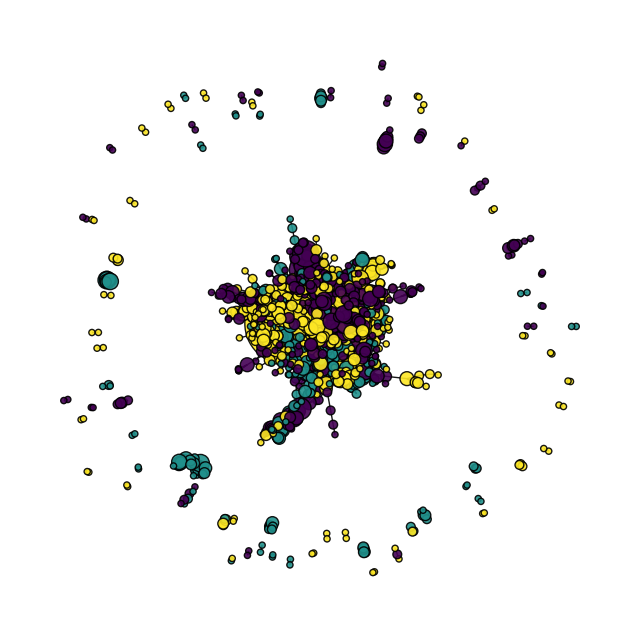

In [ ]:
# # p = 1, q=2

# # adjmat , window_size , embedding_size , walks_per_vertex , walk_length , p , q
# n2v_SE = Node2Vec(adjmat, 3, 16, 12, 3, 1, 2)
# n2v_SE.train(30, 0.05)
# embeddings = np.array(n2v_SE.get_embeddings())

# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, random_state=0,n_init=10).fit(embeddings)
# labels = kmeans.labels_
# plot_graph(G, labels)

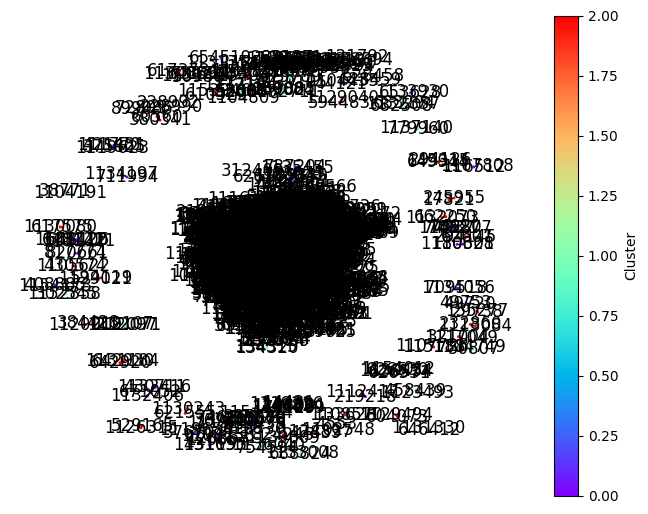

In [ ]:
# # Compute node degrees
# node_degrees = dict(G.degree())

# # Determine the maximum degree for scaling node sizes
# max_degree = max(node_degrees.values())

# # Define a scaling factor for node sizes
# scale_factor = 200  # Adjust this as needed to control the node size

# # Compute node sizes proportional to their degree
# node_sizes = [scale_factor * node_degrees[node] / max_degree for node in G.nodes]

# # Plot the graph with nodes sized by their degree
# pos = nx.spring_layout(G)  # Use a layout algorithm that suits your needs
# nx.draw(G, pos, with_labels=True, node_color=labels, cmap=plt.cm.rainbow, node_size=node_sizes)

# # Add colorbar for node colors
# sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(labels), vmax=max(labels)))
# sm.set_array([])
# plt.colorbar(sm, label='Cluster')
# plt.show()